# 1 - Les imports

In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


# 2 - Chargements des données nettoyées :

In [2]:
df = pd.read_csv("../data/processed/train_clean.csv")

df.head()


,film-url,text,sentiment,text_length
0,http://www.allocine.fr/film/fichefilm-135259/c...,Si vous cherchez du cinéma abrutissant à tous ...,0,178
1,http://www.allocine.fr/film/fichefilm-172430/c...,"Trash, re-trash et re-re-trash...! Une horreur...",0,251
2,http://www.allocine.fr/film/fichefilm-15105/cr...,"Et si, dans les 5 premières minutes du film, l...",0,100
3,http://www.allocine.fr/film/fichefilm-188629/c...,Mon dieu ! Quelle métaphore filée ! Je suis ab...,0,352
4,http://www.allocine.fr/film/fichefilm-23514/cr...,"Premier film de la saga Kozure Okami, ""Le Sabr...",1,32


# 3 - Vérification rapides :
Pour vérifier qu'aucune donnée n'est cassée, vérifier l'équilibre des classes.

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   film-url     160000 non-null  object
 1   text         160000 non-null  object
 2   sentiment    160000 non-null  int64 
 3   text_length  160000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 4.9+ MB


In [4]:
df["sentiment"].value_counts()


sentiment
1    80587
0    79413
Name: count, dtype: int64

# 4 - Nettoyage NLP du texte :

In [5]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # suppression URLs
    text = re.sub(
        r"[^a-zàâçéèêëîïôûùüÿñæœ\s]",
        "",
        text
    )  # garder caractères français
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [ ]:
df["clean_text"] = df["text"].apply(clean_text)

df[["text", "clean_text"]].head()


,text,clean_text
0,Si vous cherchez du cinéma abrutissant à tous ...,si vous cherchez du cinéma abrutissant à tous ...
1,"Trash, re-trash et re-re-trash...! Une horreur...",trash retrash et reretrash une horreur sans no...
2,"Et si, dans les 5 premières minutes du film, l...",et si dans les premières minutes du film la pa...
3,Mon dieu ! Quelle métaphore filée ! Je suis ab...,mon dieu quelle métaphore filée je suis abasou...
4,"Premier film de la saga Kozure Okami, ""Le Sabr...",premier film de la saga kozure okami le sabre ...


Nous avons normalisé le texte, réduit le bruit et conservé le sens linguistique.

# 5 - Séparation en features et cible :

In [8]:
X = df["clean_text"]

y = df["sentiment"]


# 6 - Répartition Train/Test split :

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((128000,), (32000,))

On utilise stratify=y pour m’assurer que les proportions de classes sont conservées entre le train et le test, ce qui rend l’évaluation plus fiable.

# 7 - Vectorisation TF-IDF :

In [11]:
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.shape


(128000, 10000)

On a une baseline rapide, interpretable et tres utilisée en production.
La vectorisation TF-IDF produit une matrice creuse optimisée pour le NLP, que j’utilise directement avec scikit-learn sans conversion inutile.

# 8 - Entrainement du modele :

In [13]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

# 9 - Evaluation du modèle :

In [14]:
y_pred = model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.93      0.93      0.93     15883
           1       0.93      0.93      0.93     16117

    accuracy                           0.93     32000
   macro avg       0.93      0.93      0.93     32000
weighted avg       0.93      0.93      0.93     32000



Un F1 = 0.93 sur 32 000 avis avec une baseline TF-IDF + Logistic Regression, c’est très solide.

accuracy = precision = recall = f1-score = 0.93

Le modèle TF-IDF + régression logistique obtient un F1-score de 0.93 sur le jeu de test, avec des performances équilibrées entre les classes.
Ce résultat constitue une baseline robuste pour une tâche de classification de sentiment.

# 10 - Matrice de confusion :

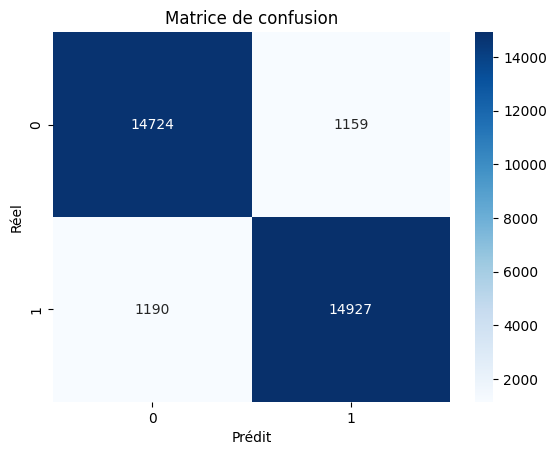

In [15]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()


Total = 32 000 observations

Interprétation métier (très importante) :
 - Faux positifs (1 159)
    Avis négatifs prédits comme positifs
    Risque : surévaluer un film médiocre

 - Faux négatifs (1 190)
    Avis positifs prédits comme négatifs
    Risque : sous-estimer un bon film

Les deux types d’erreurs sont :
    faibles (~3,7 % chacun)
    équilibrés
    sans biais systémique

C'est un excellent compromis.


La matrice de confusion montre un nombre limité et équilibré de faux positifs et de faux négatifs.
Le modèle ne présente pas de biais en faveur d’une classe et offre une performance stable sur les avis positifs comme négatifs.

# 11 - Mots les plus discriminats :

In [19]:
feature_names = tfidf.get_feature_names_out()
coef = model.coef_[0]

top_pos = np.argsort(coef)[-15:]
top_neg = np.argsort(coef)[:15]

print("Mots les plus POSITIFS :")
for i in top_pos:
    print(feature_names[i])

print("\n********************************")

print("\nMots les plus NÉGATIFS :")
for i in top_neg:
    print(feature_names[i])


Mots les plus POSITIFS :
génial
excellente
remarquable
bravo
émouvant
parfait
merveille
très bon
parfaitement
pas mal
bon film
beau film
superbe
magnifique
excellent

********************************

Mots les plus NÉGATIFS :
mauvais
ennuyeux
navet
déception
intérêt
décevant
nul
ridicule
plv
rien
raté
mal
ennui
éviter
malheureusement


Les mots les plus discriminants identifiés par le modèle sont sémantiquement cohérents avec les sentiments associés.
Cela confirme la capacité du modèle à capturer le langage subjectif exprimé dans les avis.

# 12 - Conclusion :

Nous avons un modèle baseline TF-IDF avec une régression logistique qui a été entraîné.
Les performances sont satisfaisantes pour une première approche.
Les mots les plus discriminants sont cohérents avec le sentiment exprimé.
Cette baseline servira de référence pour des améliorations futures.

# 13 - Sauvegarde :

In [21]:
import joblib

joblib.dump(model, "../models/logistic_regression_tfidf.pkl")
joblib.dump(tfidf, "../models/tfidf_vectorizer.pkl")


['../models/tfidf_vectorizer.pkl']